In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage import data
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
import cv2

import torchvision.transforms as transforms
import torchvision
import torch
import torchvision.datasets as dsets
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

In [3]:
METHOD = 'uniform'
radius = 1
n_points = 8 * radius

trans = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])
training_set = dsets.CIFAR10(root='./data', train=True,  transform=trans, download=True)
testing_set = dsets.CIFAR10(root='./data', train=False, transform=trans, download=True)

def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), normed=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')

def print_lbp_img(img, lbp_img, histogram):
    '''
    :param img: original image
    :param lbp_img: lbp image
    :param histogram: histogram of the lbp image
    :return: print the figure
    '''
    return True


def lbp_piece_vec(img, method, p, r, regions=4):
    '''
    :param img: input grayscale image
    :param method: LBP method
    :param p: number of neighbors
    :param r: radius
    :param regions: number of regions divided
    :return: lbp vector
    '''
    # crop the 32x32 image into 4 8x8 regions
    pieces = []
    vectors = []
    for i in range(regions):
        for j in range(regions):
            pieces.append(img[8*i:8*(i+1), 8*j:8*(j+1)])

    for piece in pieces:
        lbp = local_binary_pattern(piece, p, r, method)
        his, _ = np.histogram(lbp, normed=True, bins=p+2, range=(0, p+2))
        vectors.append(his)

    return np.concatenate(vectors)

def lbp_vec(img, method, p, r):
    '''
    :param img: input grayscale image
    :param method: LBP method
    :param p: number of neighbors
    :param r: radius
    :return: lbp vector
    '''
    # convert a single image into graph directly
    lbp = local_binary_pattern(img, p, r, method)
    his, _ = np.histogram(lbp, normed=True, bins=p+2, range=(0, p+2))
    return his

def LBP_data(training_set, testing_set):
    '''
    :param training_set:
    :param testing_set:
    :return: array like training and testing data
    '''
    train_lbp_vectors = []
    train_labels = []

    for img, lab in training_set:
        img = img.numpy().squeeze()
        vector = lbp_vec(img, METHOD, n_points, radius)
        train_lbp_vectors.append(np.expand_dims(vector, axis=0))
        train_labels.append(lab)

    train_img = np.concatenate(train_lbp_vectors, axis=0)
    train_lab = np.array(train_labels)


    test_lbp_vectors = []
    test_labels = []

    for img, lab in testing_set:
        img = img.numpy().squeeze()
        vector = lbp_vec(img, METHOD, n_points, radius)
        test_lbp_vectors.append(np.expand_dims(vector, axis=0))
        test_labels.append(lab)

    test_img = np.concatenate(test_lbp_vectors, axis=0)
    test_lab = np.array(test_labels)

    return train_img, train_lab, test_img, test_lab

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_img, train_lab, test_img, test_lab = LBP_data(training_set, testing_set)

# train_img, train_lab, test_img, test_lab = np.load('train_img.npy'), np.load('train_lab.npy'), np.load('test_img.npy'), np.load('test_lab.npy')

print(type(train_img), train_img.shape)
print(type(test_img), test_img.shape)
print('finished the processing of images')
# classifier = model = LinearSVC(C=100.0, random_state = 42)
classifier = LinearSVC(C=100.0, random_state = 42)

classifier.fit(train_img, train_lab)
print('fit the model')

pre_labs = classifier.predict(test_img)
print("Classification report for classifier %s:\n%s\n" % (classifier, metrics.classification_report(test_lab, pre_labs)))

/home/bob/.virtualenvs/virtual-py3/lib/python3.5/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


<class 'numpy.ndarray'> (50000, 10)
<class 'numpy.ndarray'> (10000, 10)
finished the processing of images
fit the model
Classification report for classifier LinearSVC(C=100.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0):
              precision    recall  f1-score   support

           0       0.31      0.50      0.38      1000
           1       0.29      0.51      0.37      1000
           2       0.11      0.01      0.02      1000
           3       0.23      0.03      0.05      1000
           4       0.26      0.30      0.28      1000
           5       0.26      0.46      0.33      1000
           6       0.30      0.68      0.42      1000
           7       0.31      0.05      0.08      1000
           8       0.28      0.06      0.10      1000
           9       0.25      0.21      0.23      1000

   micro avg       0.28      0.

/home/bob/.virtualenvs/virtual-py3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/home/bob/.virtualenvs/virtual-py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Support Vector Classifier :  0.2802


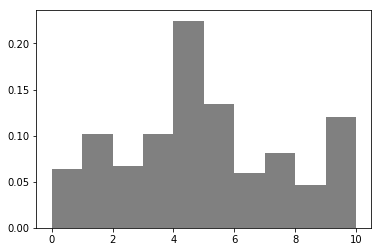

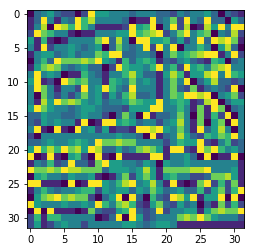

In [5]:
svc_score = metrics.accuracy_score(test_lab,pre_labs)
print("Support Vector Classifier : ", svc_score)

trans = transforms.ToPILImage()
images, labels = training_set.__getitem__(1)
lbp = local_binary_pattern(images.numpy().squeeze(), n_points, radius, METHOD)

plt.hist(lbp.ravel(), normed=True, bins=n_points+2, range=(0, n_points+2), color='0.5')
plt.show()

plt.imshow(lbp.astype("uint8"))